Verwendetes Szenario: retail
Erster Timestamp: 2026-01-01 00:00:00
Letzter Timestamp: 2026-01-10 23:50:00
Simulationshorizont: 10 Tage

Anzahl Ladesessions im Simulationshorizont: 310

Beispiel-Sessions (erste 10):
Max. gleichzeitig ladende Fahrzeuge: 12
Vorhandene Ladepunkte am Standort: 12
Fahrzeug: Q8 e-tron, Ankunft: 2026-01-01 09:52:31.614053, Abfahrt: 2026-01-01 11:32:46.825613, Kapazität: 89.0 kWh, geladene Energie: 13.6 kWh, Restbedarf: 0.0 kWh
Fahrzeug: EX30 Twin, Ankunft: 2026-01-01 10:48:24.254027, Abfahrt: 2026-01-01 11:23:45.894227, Kapazität: 69.0 kWh, geladene Energie: 13.9 kWh, Restbedarf: 42.7 kWh
Fahrzeug: Macan, Ankunft: 2026-01-01 12:12:18.653648, Abfahrt: 2026-01-01 13:06:56.000398, Kapazität: 100.0 kWh, geladene Energie: 15.7 kWh, Restbedarf: 0.0 kWh
Fahrzeug: Model Y, Ankunft: 2026-01-01 12:40:41.486842, Abfahrt: 2026-01-01 13:18:56.774131, Kapazität: 65.0 kWh, geladene Energie: 7.5 kWh, Restbedarf: 0.0 kWh
Fahrzeug: EQA, Ankunft: 2026-01-01 13:33:19.347397, Abfa

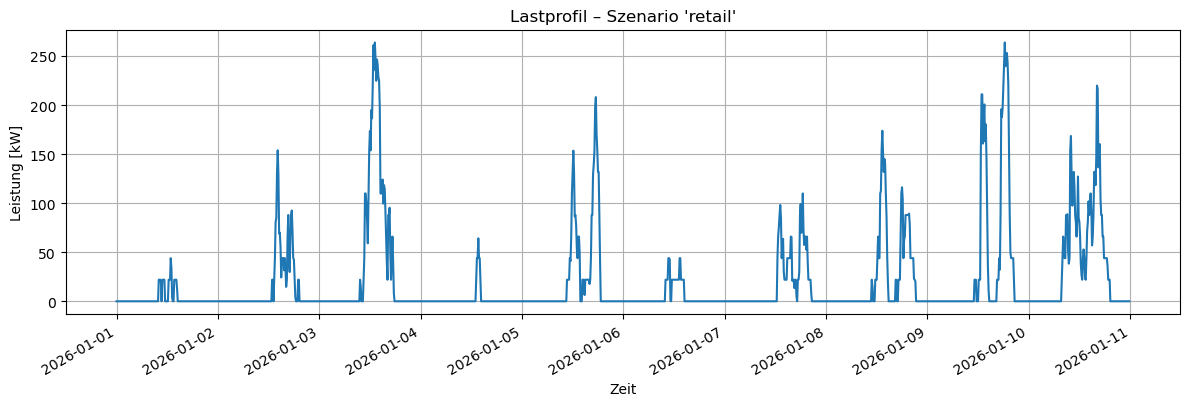

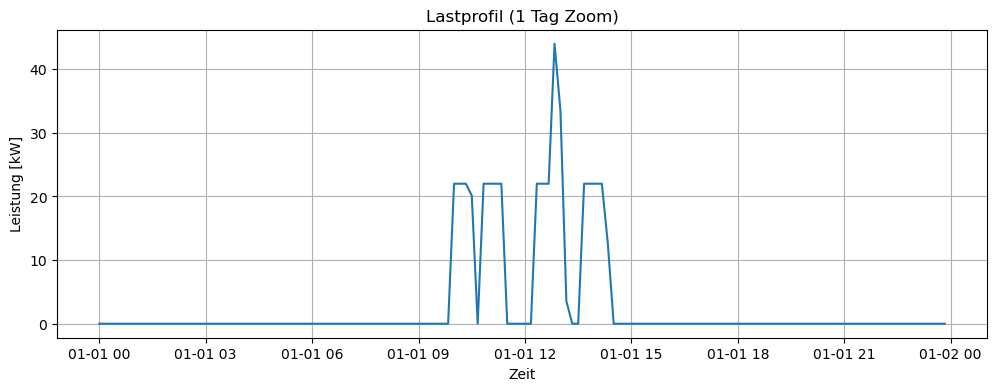

In [17]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# ---------------------------------------------------------------------------
# Projektpfad setzen, damit "model" importierbar ist
# ---------------------------------------------------------------------------
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from model.simulation import (
    load_scenario,
    simulate_load_profile,
    load_vehicle_profiles_from_csv,
)

# ---------------------------------------------------------------------------
# Szenario laden und Simulation durchführen
# ---------------------------------------------------------------------------
scenario_name = "retail"            # gewünschtes Szenario
scenario_path = f"../scenarios/{scenario_name}.yaml"

scenario = load_scenario(scenario_path)
timestamps, load_kw, sessions, charging_counts = simulate_load_profile(scenario)

# ---------------------------------------------------------------------------
# Kontrollen: Standorttyp, Zeitbereich und Simulationshorizont
# ---------------------------------------------------------------------------
print("Verwendetes Szenario:", scenario_name)
print(f"Erster Timestamp: {timestamps[0]}")
print(f"Letzter Timestamp: {timestamps[-1]}")
print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")

# ---------------------------------------------------------------------------
# Überblick: Anzahl Sessions und Beispiel-Sessions
# ---------------------------------------------------------------------------
print("\nAnzahl Ladesessions im Simulationshorizont:", len(sessions))
print("\nBeispiel-Sessions (erste 10):")
print("Max. gleichzeitig ladende Fahrzeuge:", max(charging_counts))
print("Vorhandene Ladepunkte am Standort:", scenario["site"]["number_chargers"])


for s in sessions[:10]:
    print(
        f"Fahrzeug: {s['vehicle_name']}, "
        f"Ankunft: {s['arrival_time']}, "
        f"Abfahrt: {s['departure_time']}, "
        f"Kapazität: {s['battery_capacity_kwh']} kWh, "
        f"geladene Energie: {s['delivered_energy_kwh']:.1f} kWh, "      #NEU
        f"Restbedarf: {s['energy_required_kwh']:.1f} kWh"           # NEU
    )

# ---------------------------------------------------------------------------
# Auswertung: welche Fahrzeuge wurden wie oft geladen?
# ---------------------------------------------------------------------------
vehicle_names = [s["vehicle_name"] for s in sessions]
counts = Counter(vehicle_names)

print("\nVerwendete Fahrzeuge im Simulationshorizont:")
for model, n in counts.items():
    print(f"- {model}: {n} Sessions")


# ---------------------------------------------------------------------------
# 3) Lastprofil als Diagramm
# ---------------------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(timestamps, load_kw)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(f"Lastprofil – Szenario '{scenario_name}'")
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

steps_per_day = int(24*60/scenario["time_resolution_min"])

plt.figure(figsize=(12,4))
plt.plot(timestamps[:steps_per_day], load_kw[:steps_per_day])
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title("Lastprofil (1 Tag Zoom)")
plt.grid(True)
plt.show()



Kalenderische Tage je Tagtyp:
- working_day: 5 Tage -> [datetime.date(2026, 1, 2), datetime.date(2026, 1, 5), datetime.date(2026, 1, 7), datetime.date(2026, 1, 8), datetime.date(2026, 1, 9)]
- saturday: 2 Tage -> [datetime.date(2026, 1, 3), datetime.date(2026, 1, 10)]
- sunday_holiday: 3 Tage -> [datetime.date(2026, 1, 1), datetime.date(2026, 1, 4), datetime.date(2026, 1, 6)]


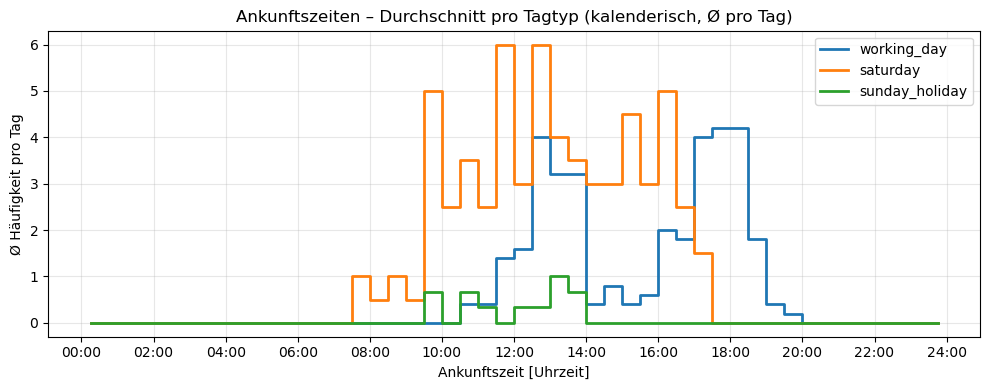

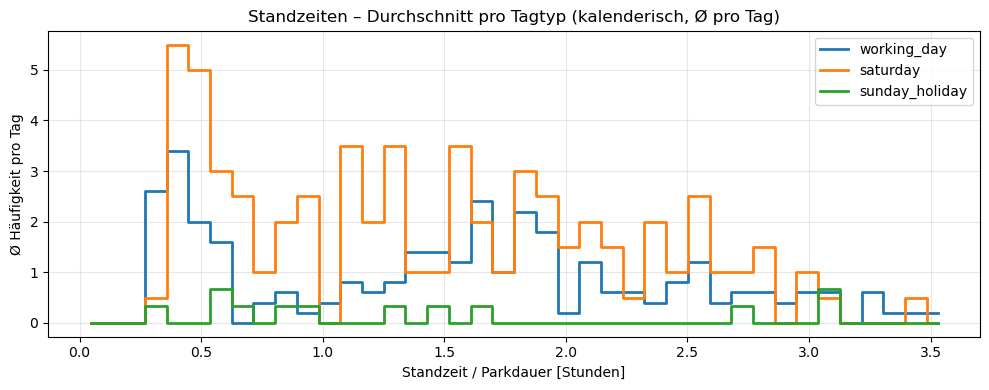

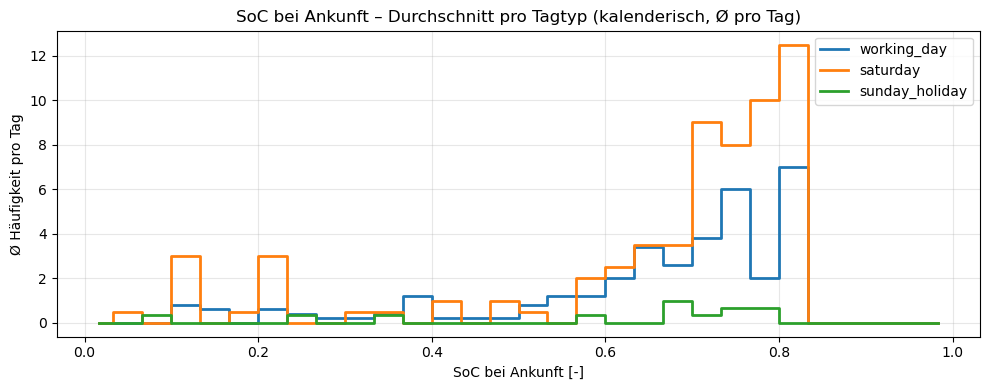

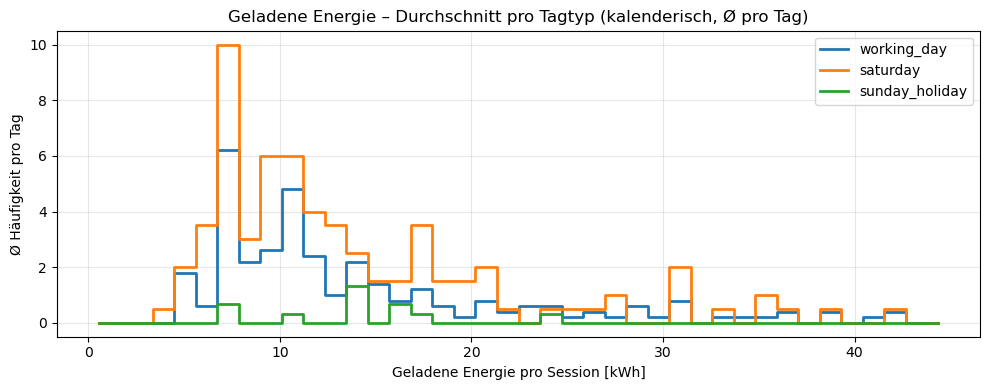

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta, date

# ---------------------------------------------------------------------
# Day-Type-Logik lokal im Notebook
# ---------------------------------------------------------------------
def determine_day_type_notebook(dt, holiday_dates):
    d = dt.date()
    if d in holiday_dates:
        return "sunday_holiday"
    wd = dt.weekday()  # Mo=0 ... So=6
    if wd == 6:
        return "sunday_holiday"
    if wd == 5:
        return "saturday"
    return "working_day"

# ---------------------------------------------------------------------
# Feature-Helper pro Session
# ---------------------------------------------------------------------
def minutes_since_midnight(dt):
    return dt.hour * 60 + dt.minute + dt.second / 60.0

def feat_arrival_hours(s):
    return minutes_since_midnight(s["arrival_time"]) / 60.0

def feat_parking_hours(s):
    return (s["departure_time"] - s["arrival_time"]).total_seconds() / 3600.0

def feat_soc_arrival(s):
    return float(s["soc_arrival"])

def feat_delivered_kwh(s):
    return float(s.get("delivered_energy_kwh", 0.0))

# ---------------------------------------------------------------------
# WICHTIG (Fix): Tage NICHT aus Sessions zählen, sondern kalendarisch
#   -> verhindert Schwankungen, wenn an einem Feiertag zufällig 0 Sessions entstehen
# ---------------------------------------------------------------------
start_dt = datetime.fromisoformat(scenario["start_datetime"])
horizon_days = int(scenario["simulation_horizon_days"])

all_days = [start_dt.date() + timedelta(days=i) for i in range(horizon_days)]

days_by_type_calendar = defaultdict(list)
for d in all_days:
    dt_midday = datetime(d.year, d.month, d.day, 12, 0)  # sicher innerhalb des Tages
    day_type = determine_day_type_notebook(dt_midday, holiday_dates)
    days_by_type_calendar[day_type].append(d)

print("Kalenderische Tage je Tagtyp:")
for k in ["working_day", "saturday", "sunday_holiday"]:
    print(f"- {k}: {len(days_by_type_calendar.get(k, []))} Tage -> {days_by_type_calendar.get(k, [])}")

# ---------------------------------------------------------------------
# Sessions nach Datum gruppieren (für Histogramme pro Tag)
#   (Tage ohne Sessions bleiben einfach leere Listen)
# ---------------------------------------------------------------------
sessions_by_day = defaultdict(list)  # key: date -> list[session]
for s in sessions:
    sessions_by_day[s["arrival_time"].date()].append(s)

# ---------------------------------------------------------------------
# Kern: Durchschnitts-Histogramm pro Tagtyp (Ø pro Tag, inkl. 0-Sessions-Tage)
# ---------------------------------------------------------------------
def average_hist_per_daytype_calendar(
    daytype_to_days: dict[str, list[date]],
    sessions_by_day: dict[date, list],
    value_fn,
    bin_edges: np.ndarray,
) -> dict[str, np.ndarray]:
    """
    Für jeden Tagtyp:
      - iteriere über ALLE kalendarischen Tage dieses Typs
      - pro Tag: Histogramm (Counts) berechnen
      - über alle Tage mitteln => Ø Counts pro Tag (je Bin)

    Vorteil:
      - Tage ohne Sessions gehen als 0 in den Mittelwert ein
      - Anzahl Tage ist deterministisch (keine Schwankung)
    """
    avg_counts_by_type: dict[str, np.ndarray] = {}
    for day_type, days in daytype_to_days.items():
        if not days:
            avg_counts_by_type[day_type] = np.zeros(len(bin_edges) - 1, dtype=float)
            continue

        daily_counts = []
        for d in days:
            sess = sessions_by_day.get(d, [])
            values = np.array([value_fn(s) for s in sess], dtype=float)
            counts, _ = np.histogram(values, bins=bin_edges)
            daily_counts.append(counts.astype(float))

        avg_counts_by_type[day_type] = np.mean(np.vstack(daily_counts), axis=0)

    return avg_counts_by_type

def plot_avg_hist_overlay(avg_counts_by_type, bin_edges, xlabel, title, xticks=None, xtick_labels=None):
    plt.figure(figsize=(10, 4))

    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    for dt_type in ["working_day", "saturday", "sunday_holiday"]:
        if dt_type not in avg_counts_by_type:
            continue
        plt.step(centers, avg_counts_by_type[dt_type], where="mid", linewidth=2, label=dt_type)

    plt.xlabel(xlabel)
    plt.ylabel("Ø Häufigkeit pro Tag")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()

    if xticks is not None:
        plt.xticks(xticks, xtick_labels if xtick_labels is not None else None)

    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 1) Ankunftszeiten: 0..24h, 30-Min-Bins
# ---------------------------------------------------------------------
arrival_bin_edges = np.linspace(0, 24, 49)  # 48 bins à 0.5h

avg_arrival = average_hist_per_daytype_calendar(
    daytype_to_days=days_by_type_calendar,
    sessions_by_day=sessions_by_day,
    value_fn=feat_arrival_hours,
    bin_edges=arrival_bin_edges,
)

plot_avg_hist_overlay(
    avg_counts_by_type=avg_arrival,
    bin_edges=arrival_bin_edges,
    xlabel="Ankunftszeit [Uhrzeit]",
    title="Ankunftszeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
    xticks=list(range(0, 25, 2)),
    xtick_labels=[f"{h:02d}:00" for h in range(0, 25, 2)],
)

# ---------------------------------------------------------------------
# 2) Standzeiten: datengetriebene Obergrenze (p99), Stunden
# ---------------------------------------------------------------------
all_parking = np.array([feat_parking_hours(s) for s in sessions], dtype=float)
max_p = np.percentile(all_parking, 99) if len(all_parking) else 1.0
max_p = max(max_p, 0.5)  # kleine Untergrenze, falls sehr wenig Daten
parking_bin_edges = np.linspace(0, max_p, 41)  # 40 bins

avg_parking = average_hist_per_daytype_calendar(
    daytype_to_days=days_by_type_calendar,
    sessions_by_day=sessions_by_day,
    value_fn=feat_parking_hours,
    bin_edges=parking_bin_edges,
)

plot_avg_hist_overlay(
    avg_counts_by_type=avg_parking,
    bin_edges=parking_bin_edges,
    xlabel="Standzeit / Parkdauer [Stunden]",
    title="Standzeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
)

# ---------------------------------------------------------------------
# 3) SoC bei Ankunft: 0..1
# ---------------------------------------------------------------------
soc_bin_edges = np.linspace(0, 1, 31)  # 30 bins

avg_soc = average_hist_per_daytype_calendar(
    daytype_to_days=days_by_type_calendar,
    sessions_by_day=sessions_by_day,
    value_fn=feat_soc_arrival,
    bin_edges=soc_bin_edges,
)

plot_avg_hist_overlay(
    avg_counts_by_type=avg_soc,
    bin_edges=soc_bin_edges,
    xlabel="SoC bei Ankunft [-]",
    title="SoC bei Ankunft – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
)

# ---------------------------------------------------------------------
# 4) Geladene Energie: datengetriebene Obergrenze (p99), kWh
# ---------------------------------------------------------------------
all_energy = np.array([feat_delivered_kwh(s) for s in sessions], dtype=float)
max_e = np.percentile(all_energy, 99) if len(all_energy) else 1.0
max_e = max(max_e, 1.0)  # Untergrenze
energy_bin_edges = np.linspace(0, max_e, 41)  # 40 bins

avg_energy = average_hist_per_daytype_calendar(
    daytype_to_days=days_by_type_calendar,
    sessions_by_day=sessions_by_day,
    value_fn=feat_delivered_kwh,
    bin_edges=energy_bin_edges,
)

plot_avg_hist_overlay(
    avg_counts_by_type=avg_energy,
    bin_edges=energy_bin_edges,
    xlabel="Geladene Energie pro Session [kWh]",
    title="Geladene Energie – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
)
